In [10]:
# ref: https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=gFsCTp_mporB
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

[nltk_data] Downloading package punkt to /opt/ml/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# load into a data frame
df = pd.read_csv("train1.csv")  
df_valid = pd.read_csv("valid1.csv")  

In [11]:
# Load the GPT tokenizer.
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [13]:
batch_size = 2

In [14]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [17]:
train_dataset = GPT2Dataset(df['사장답글'], tokenizer, max_length=256)
val_dataset = GPT2Dataset(df_valid['사장답글'], tokenizer, max_length=256)


In [18]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [19]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('skt/kogpt2-base-v2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [22]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [23]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [24]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of  76,809. Loss: 0.9374901652336121.   Elapsed: 0:00:34.
0: '에서 저희 미아중앙점을 이용해주셔서 감사해요 도 많이 )
이벤은 항상 항상 고객님께 최고의 제품으로 보답할것입니다!!!
많은 고객들의 소중한 감사금을 받아가려요 
또 한번 더 열심히 해서 더욱 보답할수 있도록 노력할테입니당!!!!!!
맛있고 소중한 리뷰 감사드립니다!!!!
더 잘 받아주시고 소중한 의견 감사드려요!!
항상 좋은 말씀 감사드립니다!!!!

요즘 코로나 조심하시고 소중한 리뷰 감사드려요ᄒ
오늘하루도 행복한 하루 되실수 있도록 즐거운 하루 되겠습니다!



오늘도 즐거운 하루 되시고 소중한 의견에 보답하기 위해

맛있는 리뷰 감사해주시트로 보답하겠습니다!
항상 맛
  Batch   200  of  76,809. Loss: 1.0197594165802002.   Elapsed: 0:01:21.
0: 澈 감사합니다님께서 선물 많이 넣으세요~!

오늘도 좋은 선물이 되겠습니다! 많은 이용부탁드려용 찾아뵐테겠습니다.
  Batch   300  of  76,809. Loss: 0.5133742094039917.   Elapsed: 0:02:07.
0: よ 맛있게 드셨다니 너무 감사드려요  
오늘도 소중한 리뷰 감사드려요 
항상 맛있도록 노력하겠습니다  
늘 행복하게 보내시길 바랍니다 
  Batch   400  of  76,809. Loss: 1.3775196075439453.   Elapsed: 0:02:52.
0: 승문 소중한 리뷰 감사드립니다 
저희 요거로룽 화이팅하세요
  Batch   500  of  76,809. Loss: 0.8339428305625916.   Elapsed: 0:03:39.
0: 󰑞 저의 주문해주시고 리뷰까지 감사합니다 ᄒᄒ ᄒ 저는 좋아하네요  ᄒ요!!
다음에도 저는 실망할 수 있는 SKY31의 단골점으로 하겠습니다

KeyboardInterrupt: 

Let's view the summary of the training process.

In [29]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.72,0.59,7:51:49,0:35:19


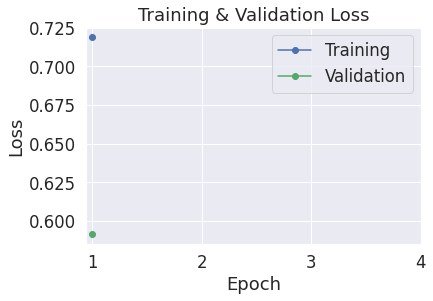

In [30]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [31]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (51203, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [25]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir, legacy_format=False)
# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


NotImplementedError: 

# Generate Text

In [35]:
model.eval()

prompt = "<|startoftext|>"
prompt = ['<|startoftext|> 가끔 시켜먹는데 양도 푸짐하고 너무 맛있어요 ㅋㅋ̄̈ 오레오 빙수도 너무 맛있네용! 용기가 깊어서 쪼금 불편하긴해요 ㅋㅋ̄̈ 맛있게 잘 먹었어요~', '<|startoftext|> 배달도 예상시간보다 빠르고 먹고나면 항상 든든해요 앞으로도 잘 부탁드려요~!', '<|startoftext|> 서비스 감사해요^^  용기가 너무 깜찍해서  기분까지  더 좋아요~~! ㅋㅋ']

for p in prompt:
  generated = torch.tensor(tokenizer.encode(p)).unsqueeze(0)
  generated = generated.to(device)

  print(generated)

  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 300,
                                  top_p=0.95, 
                                  num_return_sequences=3
                                  )

  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[51200, 19319, 19023,  7513,  9668, 15729, 11141,  8269,  9038, 12371,
         11355, 49067,  8084,   739,   605,   605,     5,     5,  9114, 15833,
         12711, 14520, 12371, 11355,  8155,  7098,  8091,   376,  9384,  9495,
          9958, 10247, 19897,  6953, 19092,  8702,  6960,  8711,  8084,   739,
           605,   605,     5,     5, 11355, 18479,  9443,  9784,  8017,  8006,
          8084,   468]], device='cuda:0')
0: 가끔 시켜먹는데 양도 푸짐하고 너무 맛있어요 ᄏᄏ 오레오 빙수도 너무 맛있네용! 용기가 깊어서 쪼금 불편하긴해요 ᄏᄏ 맛있게 잘 먹었어요~ ᄏᄏᄏᄏᄏ 저도 너무 뿌듯하고 좋아해요  맛있게 드셔주셔서 감사해요 ♥♥ 다음에도 맛있게 준비할테니 또 주문 부탁드릴게용


1: 가끔 시켜먹는데 양도 푸짐하고 너무 맛있어요 ᄏᄏ 오레오 빙수도 너무 맛있네용! 용기가 깊어서 쪼금 불편하긴해요 ᄏᄏ 맛있게 잘 먹었어요~! 주문주셔서 감사드리구 행복 가득한 하루 되시길 바랄게요 


2: 가끔 시켜먹는데 양도 푸짐하고 너무 맛있어요 ᄏᄏ 오레오 빙수도 너무 맛있네용! 용기가 깊어서 쪼금 불편하긴해요 ᄏᄏ 맛있게 잘 먹었어요~ 담번엔 맛있게 드실수있도록 더 맛있게 만들어보겠습니닷 ^3^ 리뷰 정말 감사합니다!!♥


tensor([[51200, 28005,  7235, 13814, 10785,  9518, 29578, 15495,  7055,  7532,
         12086, 14309,  7283,  8711,  8084, 12634,  7235,  9443, 19581, 45732,
      

These aren't bad at all!
